In [27]:
import torch
from builtins import range
from __future__ import division
from __future__ import print_function
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from sklearn.metrics import classification_report, log_loss
from timeit import default_timer as timer
import gc
import sys
import skimage.transform as sktr
from torchvision.models import vgg11, alexnet
import torchvision
import sklearn.linear_model as lm
from sklearn.preprocessing import normalize
%matplotlib inline

 Задание: выкинуть последний слой из vgg / alexnet и обучить линейную регрессиию на выходах полученных сетей.
Например, для mnist.

In [5]:
#10, 3, 224, 224
def image_transform(img):
    img = np.squeeze(img)
    img = sktr.resize(img, (224, 224), preserve_range = True)
    img = np.repeat(img[np.newaxis, :,:], 3, axis = 0)
    return img

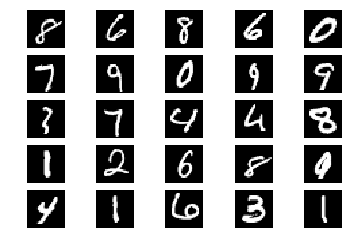

In [6]:
# обратите внимание, что данные имеют размерость examples x channels x w x h
mnist = fetch_mldata('MNIST original')
images = mnist['data']
images = images.reshape(images.shape[0], 1, 28, 28)
labels = mnist['target'].astype(int)
np.random.seed(777)
images_train, images_test, labels_train, labels_test = train_test_split(images, labels)


images_train = images_train
labels_train = labels_train
images_test = images_test
labels_test = labels_test


for i in xrange(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images_train[i, 0, :, :], cmap=plt.cm.Greys_r)
    plt.axis('off')

In [7]:
train_images_numpy = np.array([image_transform(x) for x in images_train])
test_images_numpy = np.array([image_transform(x) for x in images_test])

In [8]:
images_train = train_images_numpy.reshape(train_images_numpy.shape[0], 224 * 224, 3)
images_train = torch.from_numpy(train_images_numpy ).type(torch.FloatTensor)
images_test= test_images_numpy.reshape(test_images_numpy.shape[0], 224 * 224, 3)
images_test = torch.from_numpy(test_images_numpy).type(torch.FloatTensor)
labels_train = torch.from_numpy(labels_train)
labels_test = torch.from_numpy(labels_test)

In [10]:
alex_net = alexnet(pretrained=True)
print (alex_net.classifier)
print( alex_net.features)

Downloading: "https://s3.amazonaws.com/pytorch/models/alexnet-owt-4df8aa71.pth" to /home/dmitry/.torch/models/alexnet-owt-4df8aa71.pth
100.0%


Sequential (
  (0): Dropout (p = 0.5)
  (1): Linear (9216 -> 4096)
  (2): ReLU (inplace)
  (3): Dropout (p = 0.5)
  (4): Linear (4096 -> 4096)
  (5): ReLU (inplace)
  (6): Linear (4096 -> 1000)
)
Sequential (
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU (inplace)
  (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU (inplace)
  (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU (inplace)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU (inplace)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU (inplace)
  (12): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
)


Попробуем логистическую регрессию

In [32]:
def precompute_alex_features(X, batch_size = 50):
    sys.stdout.write("Start precompute features\n")
    computed = np.zeros(shape = (X.size()[0], 9216))
    for ind, i in enumerate(range(0, X.size()[0], batch_size)):
        sys.stdout.write("\rBatch num {}".format(ind))
        sys.stdout.flush()
        batch = Variable(X[i:i+batch_size], requires_grad = False)
        alex_train_features = alex_net.features.forward(batch)
        alex_train_features = alex_train_features.view(alex_train_features.size(0), -1)
        alex_train_features = alex_train_features.data.numpy()
        alex_train_features  = normalize(alex_train_features )
        computed[i:i+batch_size] = alex_train_features
    sys.stdout.write("\nDone")

In [ ]:
# let's precompute all features
# train
alex_train_features = precompute_alex_features(images_train)

Start precompute features
Batch num 11

In [ ]:
#test
alex_test_features = precompute_alex_features(images_test)

In [137]:
max_epoch_num = 15
batch_size = 50

model = lm.SGDClassifier(loss="log")
train_loss = list()
test_loss = list()

loss = None
classes = np.arange(10)
for epoch_num in range(max_epoch_num): 
    sys.stdout.write("Start epoch num : {}\n".format(epoch_num + 1))
    sys.stdout.write("  Training set\n")
    for ind, i in enumerate(range(0, len(images_train), batch_size), 1):
        sys.stdout.write("\r  ")
        sys.stdout.write("  Batch num {}, previous loss is {}".format(ind, loss))
        batch = alex_train_features[i:(i+batch_size), :]
        labels = labels_train[i:(i+batch_size)].numpy()
        model.partial_fit(alex_fit, labels, classes=classes)
        loss = log_loss(labels, model.predict_proba(alex_fit), labels=classes)
        train_loss.append(loss)
    sys.stdout.write("\n  Done\n")
    sys.stdout.write("  Test set")
    for ind, i in enumerate(range(0, len(images_test), batch_size), 1):
        sys.stdout.write("\r  ")
        sys.stdout.write("  Batch num {}, previous loss is {}".format(ind, loss))
        batch = alex_test_features[i:(i+batch_size), :]
        labels = labels_test[i:(i+batch_size)].numpy()
        loss = log_loss(labels, model.predict_proba(alex_fit), labels=classes)
        test_loss.append(loss)
    sys.stdout.write("\n  Done\n")
    sys.stdout.write("Done\n")



KeyboardInterrupt: 

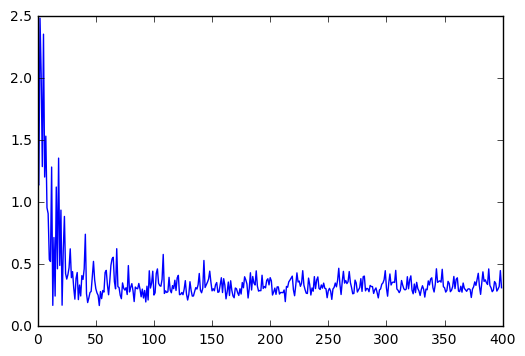

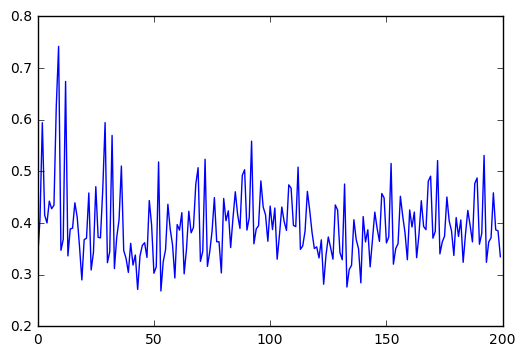

In [127]:


plt.plot(np.arange(len(train_loss)), np.array(train_loss))
plt.show()
plt.plot(np.arange(len(test_loss)), np.array(test_loss))
plt.show()

In [134]:

alex_fit = alex_net.features.forward(Variable(images_train, requires_grad = False))
alex_fit = alex_fit.view(alex_fit.size(0), -1)
alex_fit = alex_fit.data.numpy()
alex_fit = normalize(alex_fit)

model.score(alex_fit, labels_train.numpy())


0.96699999999999997

In [135]:
alex_fit = alex_net.features.forward(Variable(images_test, requires_grad = False))
alex_fit = alex_fit.view(alex_fit.size(0), -1)
alex_fit = alex_fit.data.numpy()
alex_fit = normalize(alex_fit)

model.score(alex_fit, labels_test.numpy())

0.94299999999999995

In [71]:
#26 * 26 
a = torch.LongTensor([1,2,3])
a.numpy()

array([1, 2, 3])

In [8]:
features = alex_net.features
for param in features.parameters():
    param.requires_grad = False


In [9]:
input_trans = nn.Linear(26 * 26, 224 * 224 * 3)
output_trans = nn.Linear(9216, 10)

In [26]:
channels = images_train.size(1)
class Neuro_Arch(nn.Module):
    def __init__(self):
        super(Neuro_Arch, self).__init__()
        self.input_trans = nn.Linear(28 * 28, 224 * 224 * 3)

        self.features = alex_net.features
        for param in self.features.parameters():
            param.requires_grad = 
        self.output_trans = nn.Sequential(nn.Linear(9216, 10),
                                          nn.LogSoftmax())
        

    def forward(self, x):
        print (x.size())
        x = self.input_trans.forward(x)
        
        x = x.resize(10, 3, 224, 224)
        
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output_trans(x)
        gc.collect()
        return x

In [27]:
model = Neuro_Arch()

In [28]:
a = Variable(images_train[:10], requires_grad = True)
a.resize(10, 4, 14,14).size()

hasattr(a, "requires_grad")

True

In [29]:
images_train.size()
images_train[:10].size()

torch.Size([10, 784])

Hi, Dima 

In [128]:
#was copied from previous homework
def print_work_time(func):
    def wrapper(*args, **kwargs):
        start = timer()
        result = func(*args, **kwargs)
        end = timer()
        print("Execution take {}".format(end - start))
        return result
    return wrapper

@print_work_time
def learn_on_model(X, Y, model, loss_fn, X_test = None, Y_test = None, learning_rate = 1e-2, 
                   batch_size = 100, max_epoch_num = 1, min_loss = 1e-3): 



    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)    
    loss = 1000
    epoch_num = 0
     
    loss_arr = list()

    test_loss_arr = list() if not (type(X_test) is None) else None
    tot_err = 10**6
    X = X.numpy().copy()
    Y = Y.numpy().copy()

    while tot_err > min_loss and epoch_num < max_epoch_num:
        model = model.eval()
        perm = np.random.permutation(X.shape[0])
        X = X[perm]
        Y = Y[perm]
        tot_err = 0
        sys.stdout.write("Epoch {} ...\n".format(epoch_num + 1))
        for bn, start in enumerate(xrange(0, X.shape[0], batch_size)):
            optimizer.zero_grad()
            if bn % 100 == 0:
                sys.stdout.write("Train Batch {}\n".format(bn))
            X_CUR = Variable(torch.from_numpy(X[start:start + batch_size]))
            Y_CUR = Variable(torch.from_numpy(Y[start:start + batch_size]), requires_grad=False)
            output =  model.forward(X_CUR)
            loss = loss_fn(output, Y_CUR)
            loss_arr.append(loss.data.tolist()[0])
            tot_err += loss
            loss.backward()
            optimizer.step()
            del loss
            del X_CUR
            del Y_CUR
            del output

        
        if not (type(X_test) is None):
            model = model.train()
            for bn, start in enumerate(xrange(0, X_test.size()[0], batch_size)):
                if bn % 100 == 0:
                    sys.stdout.write("Test Batch {}\n".format(bn))
                X_CUR = Variable(X_test[start:start + batch_size])
                Y_CUR = Variable(Y_test[start:start + batch_size])
                y_pred = model.forward(X_CUR)
                loss = loss_fn(y_pred, Y_CUR)
                test_loss_arr.append(loss.data.tolist()[0])
                del X_CUR
                del Y_CUR
                del y_pred
                del loss
            
            
        epoch_num += 1
        gc.collect() # only this've helped to save process from beeing kill
    model = model.train()
    return np.array(loss_arr), np.array(test_loss_arr)

def draw_plots(model, loss_arr, layer_arr, test_loss_arr, show_weights = False):
    x = np.arange(loss_arr.shape[0]);
    number_of_plots = 1 + sum(len(x) for x in layer_arr)
    gridSize = number_of_plots
    plt.figure(figsize=(15, 6 * number_of_plots))
    
    plotId = 1
    subpl = plt.subplot(gridSize, 1, plotId)
    if not type(test_loss_arr) is None:
        subpl.plot(x, loss_arr, x, test_loss_arr)
        subpl.legend(["Train", "Test"])
    else:
        subpl.plot(x, loss_arr)
    subpl.set_xticks(range(x.shape[0]))
    subpl.set_title("Loss function")
    subpl.set_xlabel("Epoch num")
    subpl.set_ylabel("Loss func")
    if show_weights:
        for ind1, child in enumerate(model.children()):
            for ind2, key in enumerate(child.state_dict().keys()):
                plotId += 1
                subpl = plt.subplot(gridSize, 1, plotId)
                y = layer_arr[ind1][ind2]
                subpl.plot(x, y)

                subpl.set_xticks(range(x.shape[0]))
                subpl.set_title("Layer {} : {} gradient norm".format(ind1 + 1, key))
                subpl.set_xlabel("Epoch num")
                subpl.set_ylabel(key + "_grad")
    
    plt.show()

from sklearn.metrics import classification_report

def make_classification_report(model, X_TRAIN, Y_TRAIN, X_TEST, Y_TEST, batch_size = 10):
    model = model.eval()
    print ("Train report")
    y_predicted = np.zeros(shape = (Y_TRAIN.size()[0], 10))
    
    for bn, start in enumerate(xrange(0, X_TRAIN.size()[0], batch_size)):
        if bn % 100 == 0:
            sys.stdout.write("Batch {}\n".format(bn))
        X_CUR = Variable(X_TRAIN[start:start + batch_size])
        
        
        y_predicted[start:start + batch_size] = np.array(model.forward(X_CUR).data.tolist())
    indices = np.argmax(y_predicted, axis = 1)
    print (classification_report(np.array(Y_TRAIN.tolist()), indices))
    print ("Accuracy", np.mean(np.array(Y_TRAIN.tolist()) == indices))
    
    print ("Test report")
    y_predicted = np.zeros(shape = (Y_TEST.size()[0], 10))
    for bn, start in enumerate(xrange(0, X_TEST.size()[0], batch_size)):
        if bn % 100 == 0:
            sys.stdout.write("Batch {}\n".format(bn))
        X_CUR = Variable(X_TEST[start:start + batch_size])
        y_predicted[start:start + batch_size] = np.array(model.forward(X_CUR).data.tolist())
        del X_CUR
        
    
    
    indices = np.argmax(y_predicted, axis = 1)
    print (classification_report(np.array(Y_TEST.tolist()), indices))
    print ("Accuracy", np.mean(np.array(Y_TEST.tolist()) == indices))

    


In [36]:


print (len(update_parameters))

for param in model.parameters():
    if param.requires_grad == True:
        update_parameters.append(param)


22


In [38]:
model = Neuro_Arch()
loss_fn = torch.nn.NLLLoss(size_average=True)


learning_rate = 1e-4

optimizer = torch.optim.Adam(list(model.output_trans.parameters()) + list(model.input_trans.parameters()), lr=learning_rate)


loss_arr, test_loss_arr = learn_on_model( images_train[:1000], labels_train[:1000], model, loss_fn,images_test[:1000],\
                                                    labels_test[:1000],\
                                                    learning_rate,\
                                                    max_epoch_num=15, batch_size = 10)


Epoch 1 ...
Train Batch 0
torch.Size([10, 784])
torch.Size([10, 784])
torch.Size([10, 784])
torch.Size([10, 784])


KeyboardInterrupt: 

Теряем почти все временные преимущества дообучения сети. Попробуем просто ресайзить изображение с помощью skimage

In [41]:
import skimage.transform as sktr

In [71]:
a = sktr.resize(images_test[1].int().numpy().reshape(28,28), (224, 224))
a = sktr.resize(a, (28,28) )

In [62]:
from skimage import data
image = data.camera()

In [92]:
((sktr.resize(images_test[1].int().numpy().reshape(28,28), (224, 224, 3), preserve_range = True)) > 100).sum()

6594

In [84]:
?sktr.resize

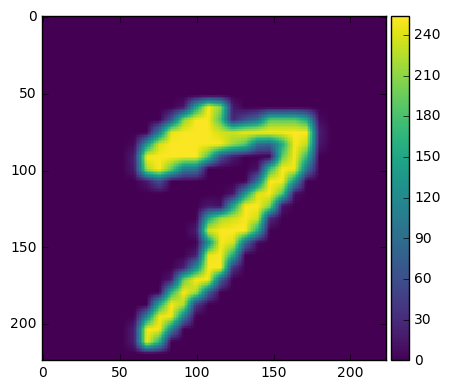

In [97]:
skimage.io.imshow(sktr.resize(images_test[1].int().numpy().reshape(28,28), (224, 224), preserve_range = True))

In [91]:
?sktr.resize

In [98]:
a = sktr.resize(images_test[1].int().numpy().reshape(28,28), (224, 224), preserve_range = True)

In [110]:
images_test.size()

torch.Size([17500, 784])

In [126]:
img_arr = list()

for x in images_test.int().numpy():
    x = sktr.resize(x.reshape(28,28), (224, 224), preserve_range = True)
    x = np.repeat(a[:,:,np.newaxis], 3, axis = -1)

In [133]:
a = np.array(img_arr)

NameError: name 'img_arr' is not defined